# Oil Price Analysis

- Loading Oil Price Data

- Understanding the Data

- Simple Summary Statistic

- Handling Missing Values

- Handling Duplicates

- Handle Outliers if any

- Data Visualization

Import neccessary libraries and modules

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in scripts/
from data_preprocessor import DataPreprocessor
from data_visualizer import DataVisualizer

logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

**Data Collection**

- Download the brent oil price data

In [4]:
# Set google drive url for loading the dataset
url = 'https://drive.google.com/file/d/1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5/view?usp=drive_link'

# Setup the data preprocessor class
processor = DataPreprocessor(url, logger=logger)
# Load the data
price_data = processor.load_data()

INFO:logger:Directory checked/created: ../data/
INFO:logger:Starting download from Google Drive.
Downloading...
From: https://drive.google.com/uc?export=download&id=1dJfhjX57bjvFnc1HHYVUhyW939QjIQE5
To: /home/noh/10Academy/oil-price-statistical-modeling/data/data.csv
100%|██████████| 156k/156k [00:00<00:00, 367kB/s]
INFO:logger:File downloaded successfully to ../data/data.csv.
INFO:logger:Data loaded into DataFrame successfully.


**Note**: always check <a href="../logs/notebooks.log">Log</a> file for any log messages

In [ ]:
# Explore the first 10 rows
price_data.head(10)

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
1987-05-27,18.60
1987-05-28,18.60
1987-05-29,18.58
1987-06-01,18.65


In [4]:
# Explore the last 10 rows
price_data.tail(10)

,Price
Date,
2022-11-01,95.12
2022-11-02,96.07
2022-11-03,95.29
2022-11-04,99.53
2022-11-07,99.87
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37


### Data Cleaning and Preprocessing

Inspect the dataset for completeness and structure

In [5]:
processor.inspect(price_data)

Dimensions (rows, columns): (9011, 2)

Data Types:
Date     datetime64[ns]
Price           float64
dtype: object

No missing values found.

Unique Values in Each Column:
Date     9011
Price    5015
dtype: int64
Number of duplicate rows: 0

Summary Statistics for Numeric Columns:


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


### Exploratory Data Analysis

In [6]:
# Create instances of the DataVisualizer class
visualizer = DataVisualizer(price_data, logger = logger)

**Detect Outliers**

- Box plot

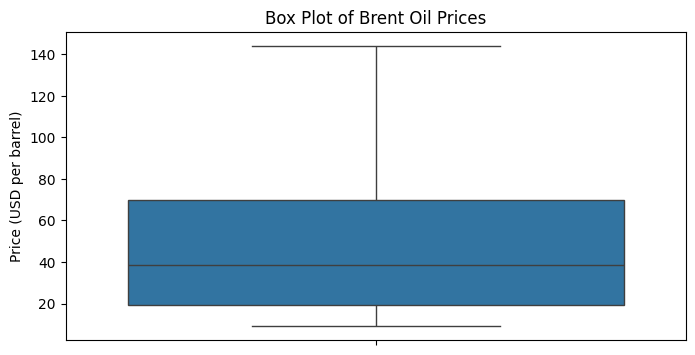

In [4]:
visualizer.plot_box()

- No outliers detected in the price data

- Descriptive Statistics

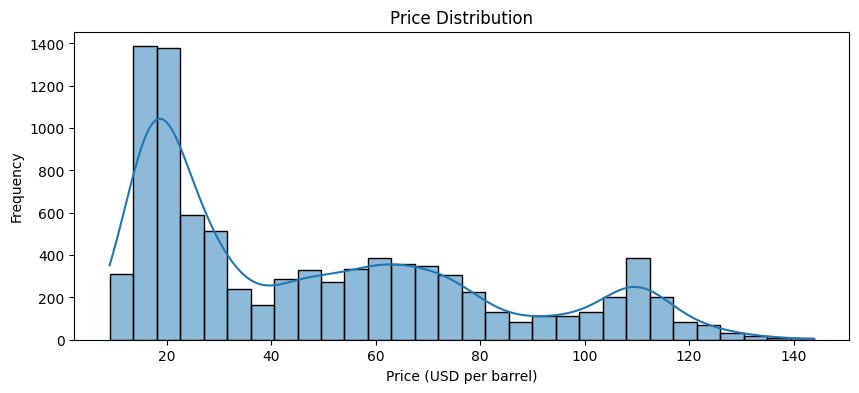

In [5]:
# Visualize the price distribution
visualizer.plot_price_distribution()


**Time Series Analysis**
- Overall price trend

    - Create a line graph to visualize price trends over time.

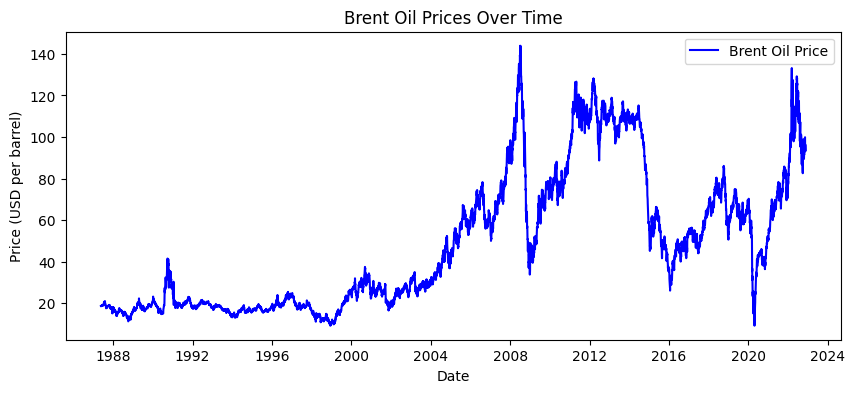

In [7]:
visualizer.plot_price_over_time()


- **Seasonality Analysis**
    - Aggregate prices by year and visualize seasonal patterns.

/home/noh/10Academy/oil-price-statistical-modeling/scripts/data_visualizer.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Price', data=yearly_avg, palette='viridis')


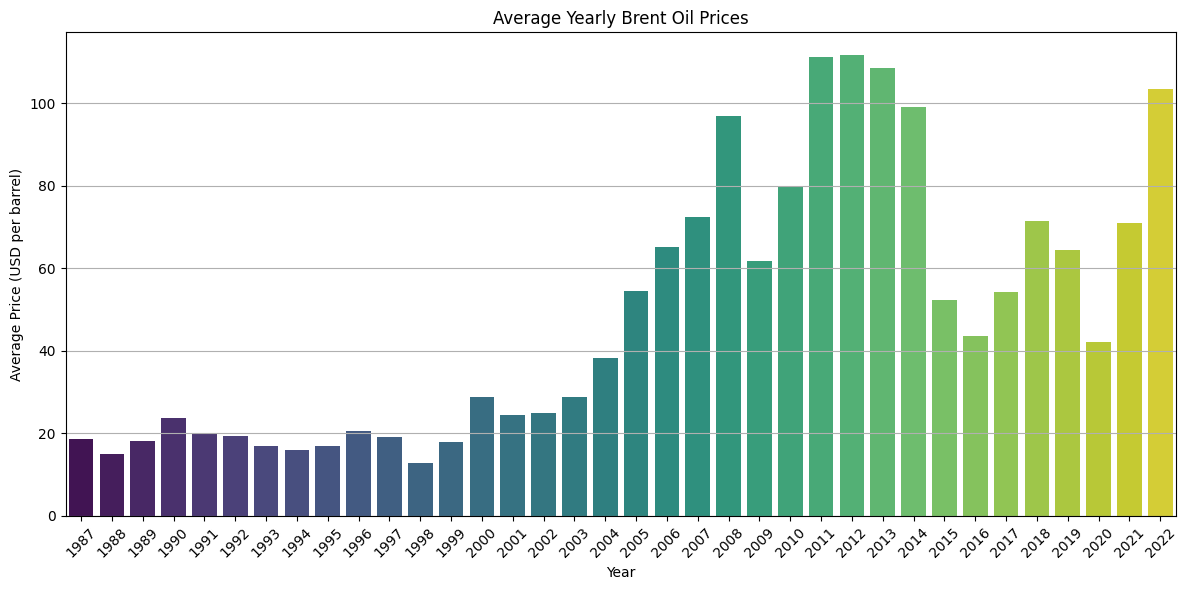

In [10]:
visualizer.plot_yearly_average()

- **Rolling Volatility Analysis**

    - Rolling standard deviation (e.g., 30-day) line plot of prices.

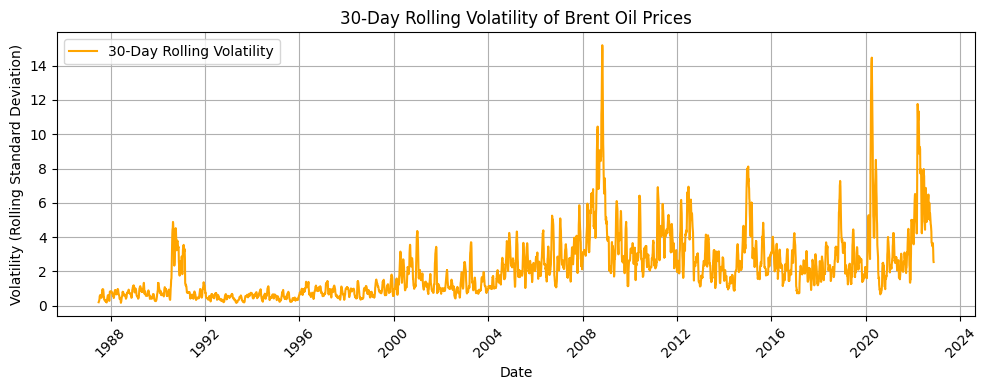

In [12]:
# 30-Day Volatile
visualizer.plot_rolling_volatility(30)

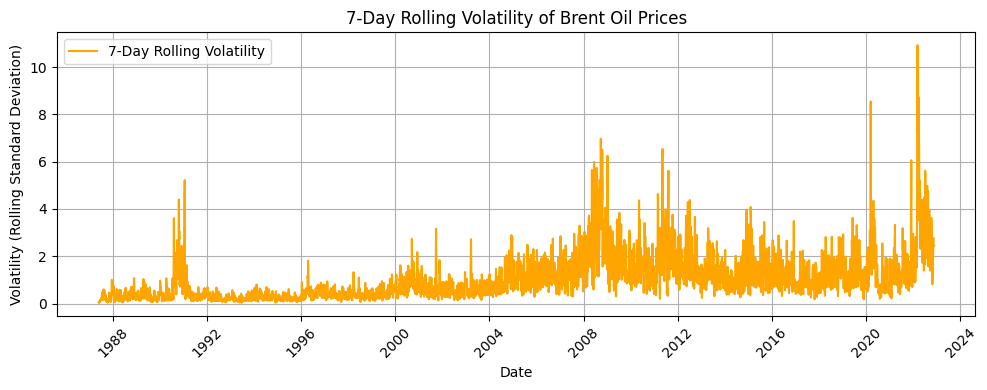

In [13]:
# 7-Day volatile
visualizer.plot_rolling_volatility(7)

**Seasonal Decomposition**

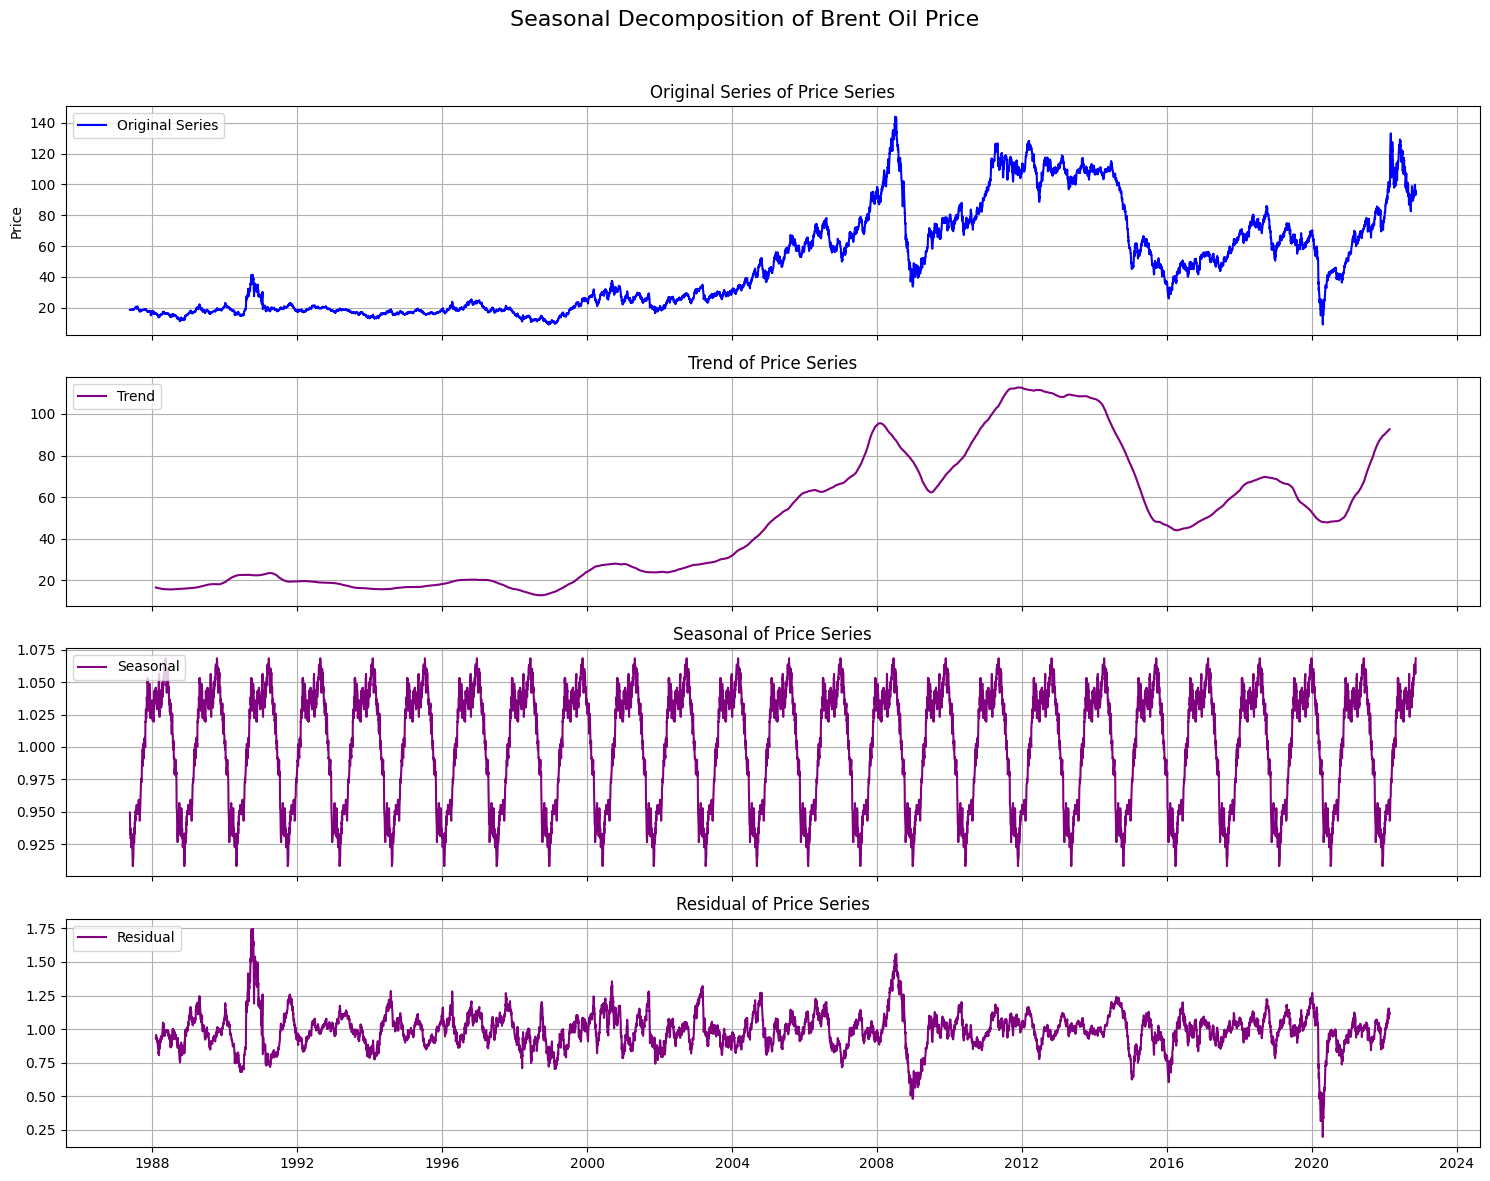

In [11]:
# Apply seasonal decomposition (use model='multiplicative' for data with proportional seasonal effects)
result = seasonal_decompose(price_data['Price'], model='multiplicative', period=365)  # Adjust period if necessary

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
components = ['Original Series', 'Trend', 'Seasonal', 'Residual']
series = [price_data['Price'], result.trend, result.seasonal, result.resid]

for ax, comp, ser in zip(axes, components, series):
    ax.plot(price_data.index, ser, label=comp, color='b' if comp == 'Original Series' else 'purple')
    ax.set_title(f'{comp} of Price Series')
    ax.set_ylabel('Price' if comp == 'Original Series' else '')
    ax.grid(True)
    ax.legend(loc='upper left')

# Improve layout and display the plot
fig.suptitle('Seasonal Decomposition of Brent Oil Price', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
plt.show()

**Stationaly Analysis of Time Series Data**

- Apply the Augmented Dickey-Fuller (ADF) Test

ADF Statistic: -11.250179655838952
p-value: 1.719784457068474e-20
Critical Values:
   1%: -3.431079878822629
   5%: -2.8618625589084705
   10%: -2.566941693085751
The ADF test suggests the series is stationary.


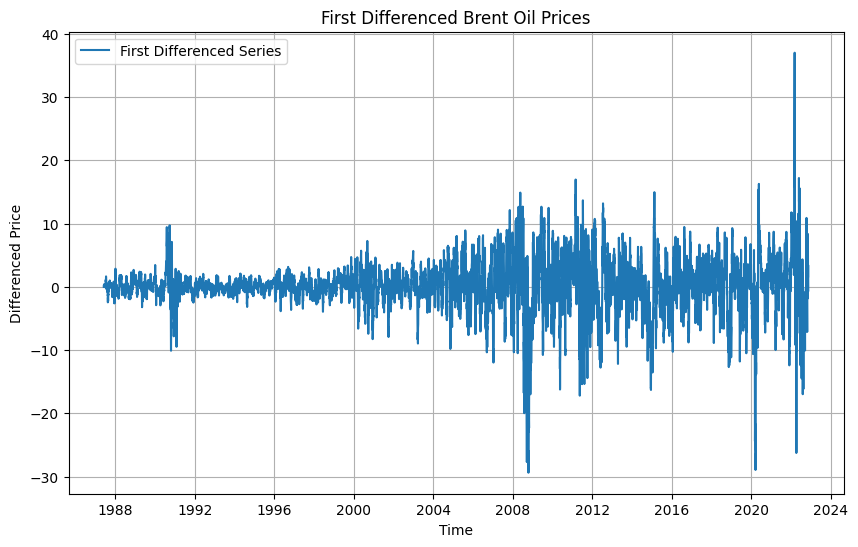

(-11.250179655838952, 1.719784457068474e-20)

In [12]:
def test_stationarity(series, title, label, alpha=0.05):
    adf_result = adfuller(series)
    
    # Print ADF results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')
    
    # Interpretation
    if adf_result[1] < alpha:
        print("The ADF test suggests the series is stationary.")
    else:
        print("The ADF test suggests the series is not stationary.")

    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(series, label=label)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Differenced Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return adf_result[0], adf_result[1]  # Returning ADF statistic and p-value for further use

# Assuming 'price_data' is your DataFrame with a 'Price' column
data = price_data['Price']

# First differencing
data_diff = data.diff(12).dropna()
test_stationarity(data_diff, title='First Differenced Brent Oil Prices', label='First Differenced Series')

ADF Statistic: -16.42711349448597
p-value: 2.498580161142495e-29
Critical Values:
   1%: -3.4310783342658615
   5%: -2.861861876398633
   10%: -2.566941329781918
The ADF test suggests the series is stationary.


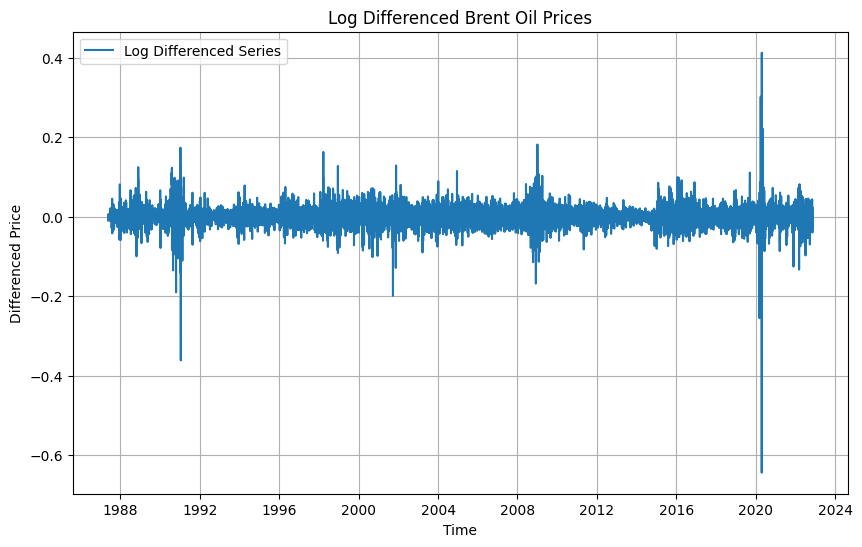

(-16.42711349448597, 2.498580161142495e-29)

In [13]:
# Log transformation
log_data = np.log(price_data['Price'])
log_data_diff = log_data.diff().dropna()
test_stationarity(log_data_diff, title='Log Differenced Brent Oil Prices', label='Log Differenced Series')
